<a href="https://colab.research.google.com/github/gopalm-ai/Quantum_Machine_Learning_An_Applied_Approach/blob/main/VQE_qiskit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# VQE Algorithm

In [2]:
! pip3 install qiskit

     |████████████████████████████████| 6.4 MB 7.7 MB/s 
     |████████████████████████████████| 18.0 MB 569 kB/s 
     |████████████████████████████████| 238 kB 44.7 MB/s 
     |████████████████████████████████| 200 kB 47.9 MB/s 
     |████████████████████████████████| 53 kB 959 kB/s 
     |████████████████████████████████| 1.6 MB 46.2 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 38.2 MB 1.7 MB/s 
     |████████████████████████████████| 943 kB 51.9 MB/s 
     |████████████████████████████████| 38.1 MB 379 kB/s 
     |████████████████████████████████| 49 kB 6.5 MB/s 
     |████████████████████████████████| 3.6 MB 47.2 MB/s 
     |████████████████████████████████| 112 kB 58.7 MB/s 
  Created wheel for qiskit: filename=qiskit-0.34.1-py3-none-any.whl size=11771 sha256=172357571c7c39994fea68014844d6c3519f92da72f71c71c9fd3fcb794ac6c8
  Stored in directory: /root/.cache/pip/wheels/79/b1/3f/8cdfd5543a84705e4bd16e081f2362b9b3bfd9898d2e2d

In [3]:
import numpy as np
from qiskit import *
# Define the Pauli matrices
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-np.complex(0,1)],[np.complex(0,1),0]])
Z = np.array([[1,0],[0,-1]])

In [4]:
# Compute the tensor product of the Pauli matrices
XX = np.kron(X,X)
YY = np.real(np.kron(Y,Y)) # This will be a real matrix
ZZ = np.kron(Z,Z)
II = np.identity(4)
print("The XX gate is: \n{} \n".format(XX))
print("The YY gate is: \n{} \n".format(YY))
print("The ZZ gate is: \n{} \n".format(ZZ))
print("The II gate is: \n{} \n".format(II))

The XX gate is: 
[[0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 0 0]] 

The YY gate is: 
[[ 0.  0.  0. -1.]
 [ 0.  0.  1.  0.]
 [ 0.  1.  0.  0.]
 [-1.  0.  0.  0.]] 

The ZZ gate is: 
[[ 1  0  0  0]
 [ 0 -1  0  0]
 [ 0  0 -1  0]
 [ 0  0  0  1]] 

The II gate is: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 



In [5]:
# This is the decomposition of the "M" matrix
M = (XX+YY+ZZ+II)/2
print('M = \n', M)
print('')

M = 
 [[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]



In [6]:
# Visualize Ansatz Circuit
theta = np.pi
q = QuantumRegister(2)
c = ClassicalRegister(2)
circuit = QuantumCircuit(q, c)
circuit.h(q[0])
circuit.rz(theta, q[0])
circuit.cx(q[0], q[1])
circuit.x(q[1])
circuit.barrier()
circuit.draw()

┌───┐┌───────┐           ░ 
q0_0: ┤ H ├┤ Rz(π) ├──■────────░─
      └───┘└───────┘┌─┴─┐┌───┐ ░ 
q0_1: ──────────────┤ X ├┤ X ├─░─
                    └───┘└───┘ ░ 
c0: 2/═══════════════════════════

In [7]:
# Function Definition
def ansatz(circuit,q,c,theta):
  '''
  The Ansatz wave function
  |psi> = (I X)(CX)(Rz(theta) I)(H I)|00>
  '''
  circuit.h(q[0])
  circuit.rz(theta, q[0])
  circuit.cx(q[0], q[1])
  circuit.x(q[1])
  circuit.barrier()

  return circuit

In [8]:
def measure_ZZ(circuit, N_shots=2**10, simulator_backend='qasm_simulator'):
  '''
  Measures the expectation value of ZZ on the 2-qubit states
  <ZZ> = (number of (00) and (11) states) - (number of (01) and (10) states)
  normalized over the number of trials
  '''
  simulator = Aer.get_backend(simulator_backend)
  result = execute(circuit, backend=simulator, shots=N_shots).result()

  items = result.get_counts().items()

  s=0
  for key, counts in items:
    s += (-1)**(int(key[0])+int(key[1]))*counts
  s = s/N_shots
  
  return s

In [9]:
def hamiltonian(theta, N_shots=2**10):
  '''
  The hamiltonian for the problem corresponding to the matrix M:
  M = (1/2)*(XX+YY+ZZ+II)
  The hamiltonian is computed by separating it into three components according 
  to discussions in previous cells.
  '''

  q = QuantumRegister(2)
  c = ClassicalRegister(2)

  ## 0.5*XX component
  circuit_xx = QuantumCircuit(q,c)
  circuit_xx = ansatz(circuit_xx, q, c, theta)
  circuit_xx.h(q[0])
  circuit_xx.h(q[1])
  circuit_xx.measure(q,c)
  E_XX = 0.5*measure_ZZ(circuit_xx, N_shots=N_shots)

  ## 0.5*YY component
  circuit_yy = QuantumCircuit(q,c)
  circuit_yy = ansatz(circuit_yy, q, c, theta)
  circuit_yy.sdg(q[0])
  circuit_yy.h(q[0])
  circuit_yy.sdg(q[1])
  circuit_yy.h(q[1])
  circuit_yy.measure(q,c)
  E_YY = 0.5*measure_ZZ(circuit_yy, N_shots=N_shots)

  ## 0.5*ZZ component
  circuit_zz = QuantumCircuit(q,c)
  circuit_zz = ansatz(circuit_zz, q, c, theta)
  circuit_zz.measure(q,c)
  E_ZZ = 0.5*measure_ZZ(circuit_zz, N_shots=N_shots)

  # The - 1/2 comes from the fact the <psi|II|psi> - 1
  # it is always a constant

  return (E_XX + E_YY + E_ZZ - 0.5)

In [10]:
# Minimum Expectation Value of M

In [11]:
# Generate several thetas, and find best set of parameters 
import matplotlib.pyplot as plt
# Number of shots to run
N_shots = 2**10

In [12]:
# Generate theta grid
theta = np.linspace(0.0, 2*np.pi, 200)
E = np.zeros(len(theta))

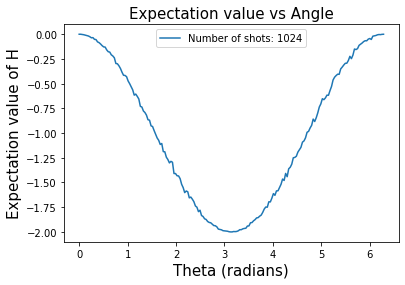

In [13]:
# Calculate expectation value of Hamiltonian for different thetas
for k in range(len(theta)):
  E[k] = hamiltonian(theta=theta[k], N_shots=N_shots)

# Plot results
plt.title('Expectation value vs Angle', fontsize=15)
plt.ylabel('Expectation value of H', fontsize=15)
plt.xlabel('Theta (radians)', fontsize=15)
plt.plot(theta, E, label='Number of shots: {}'.format(N_shots))
plt.legend()
plt.show()

In [14]:
# Determine lowest bound from varying theta
print('='*100)
print('The minimum bound on the lowest eigenvalue of M is E0={};\n'.format(min(E)))
print('The parameter that corresponds to this energy is theta={:0.2f} Rads'.format(theta[np.argmin(E)]))
print('='*100)

The minimum bound on the lowest eigenvalue of M is E0=-2.0;

The parameter that corresponds to this energy is theta=3.13 Rads


In [16]:
w, v = np.linalg.eig(M)

print('='*100)
print('Minimum eigenvalue using classical computer: Lambda={:0.2f}'.format(min(w)))
print('The minimum bound of the Eigenvalue from the quantum computing simulations is E={:0.2f}'.format(min(E)))
print('='*100)

Minimum eigenvalue using classical computer: Lambda=-1.00
The minimum bound of the Eigenvalue from the quantum computing simulations is E=-2.00
